# Vectorization and clusterization of notes using Doc2Vec, TF-IDF and KNN algorithms

## Create and activate Python environment

In [1]:
!python3 -m venv ./venv
!source ./venv/bin/activate

## Install packages

In [2]:
!python3 -m pip install nltk scikit-learn
!python3 -m pip install --upgrade gensim

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Load data

In [3]:
import json
import random

with open('notes.json') as f:
    notes = json.load(f)

random.shuffle(notes)

print(f"dataset size: {len(notes)}")

dataset size: 133


## Preprocess text data

In [4]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

print(f"Initial note:\n{notes[0]}\n\nPreprocessed:\n{preprocess_text(notes[0])}")

Initial note:
JSON Web Tokens (JWT) are a compact, URL-safe means of representing claims to be transferred between two parties. They are commonly used for authentication and authorization in web applications.

Preprocessed:
['json', 'web', 'tokens', 'jwt', 'compact', 'means', 'representing', 'claims', 'transferred', 'two', 'parties', 'commonly', 'used', 'authentication', 'authorization', 'web', 'applications']


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pierreportal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierreportal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from gensim.models.doc2vec import TaggedDocument

processed_notes = [preprocess_text(note) for note in notes]

tagged_data = [TaggedDocument(words=note, tags=[str(i)]) for i, note in enumerate(processed_notes)]

In [6]:
print(tagged_data[0])

TaggedDocument<['json', 'web', 'tokens', 'jwt', 'compact', 'means', 'representing', 'claims', 'transferred', 'two', 'parties', 'commonly', 'used', 'authentication', 'authorization', 'web', 'applications'], ['0']>


## Load and train the Doc2Vec model

In [7]:
from gensim.models import Doc2Vec

vector_size=50
min_count=1
epochs=100

doc2vec_model = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [8]:
note_vectors = [doc2vec_model.infer_vector(note) for note in processed_notes]
note_vectors[0]

array([-0.3574874 , -0.04896715, -0.19929539,  0.25255084, -0.3358077 ,
       -0.23525804, -0.19356723, -0.00883638, -1.0396907 , -0.20819733,
       -0.23664609, -0.21376269, -0.2304965 , -0.07913554, -0.05454179,
       -0.21947141,  0.6132432 , -0.1554605 , -0.6515211 , -0.2790046 ,
       -0.21755606,  0.13089448,  0.21050881, -0.33144477,  0.17560759,
       -0.37724534, -0.05441528, -0.32884297, -0.5300656 , -0.00207941,
        0.5489256 ,  0.51481676, -0.3386843 ,  0.6818777 , -0.6457552 ,
        0.38804582,  0.17275125, -0.53416854,  0.08697488, -0.49688873,
        0.9132737 , -0.06960487, -0.40571678, -0.09020646,  0.69597435,
        0.07026599, -0.11673794, -0.53771967,  0.55781746, -0.22779465],
      dtype=float32)

## Fit the vectors to the NearestNeighbors model

**n_jobs** *int, default=None*<br>
The number of parallel jobs to run for neighbors search.<br>
**None** means 1 unless in a joblib.parallel_backend context.<br> 
**-1** means using all processors.

**p** *float (positive), default=2*<br>
Parameter for the Minkowski metric from sklearn.metrics.pairwise.pairwise_distances.<br>
When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2)<br>
for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

**radius** *float, default=1.0*<br>
Range of parameter space to use by default for radius_neighbors queries.<br>
`radius_neighbors queries`: Find the neighbors within a given radius of a point or points.
Return the indices and distances of each point from the dataset lying in a ball with size radius 
around the points of the query array. Points lying on the boundary are included in the results.
The result points are not necessarily sorted by distance to their query point.

**algorithm** *{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’*<br>
Algorithm used to compute the nearest neighbors:<br>
‘ball_tree’ will use BallTree<br>
‘kd_tree’ will use KDTree<br>
‘brute’ will use a brute-force search.<br>
‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.

In [9]:
from sklearn.neighbors import NearestNeighbors

n_neighbors=5
radius=0.4
algorithm='auto' #(default)
metric='minkowski' #(default)
p=2

def evaluate(vectors, configs):
    algorithm, metric = configs
    
    X = np.array(vectors)

    
    nn_model = NearestNeighbors(

        n_neighbors = n_neighbors, 
        radius      = radius, 
        algorithm   = algorithm,
        metric      = metric

    ).fit(X)

    distances, indices = nn_model.kneighbors(X)

    print(f"For a reference note X, retrieve the {n_neighbors-1} most similar notes.")
    print(f"\nAlgorithm used: {algorithm}\nMetric: {metric}")

    for i, note in enumerate(notes[:4]):
        print(f"\n\n**Note reference**:\n{note[:80]}...\n\n**Similar notes:**")
        for j in indices[i]:
            if i != j:  # Skip the note itself
                print(f" --> {notes[j][:80]}...")
    return nn_model
                
nn_model1 = evaluate(note_vectors,[algorithm, metric])

For a reference note X, retrieve the 4 most similar notes.

Algorithm used: auto
Metric: minkowski


**Note reference**:
JSON Web Tokens (JWT) are a compact, URL-safe means of representing claims to be...

**Similar notes:**
 --> Gulp is a task runner for automating repetitive tasks in your development workfl...
 --> Concurrency is the ability of different parts of a program to execute independen...
 --> The role of ethical hacking in identifying and mitigating security vulnerabiliti...
 --> Introduction to Docker containers for packaging applications and their dependenc...


**Note reference**:
An overview of software engineering principles, methodologies, and practices....

**Similar notes:**
 --> Essential skills for software engineers, career paths (like front-end, back-end,...
 --> Ethical considerations in software development, including privacy, security, acc...
 --> Challenges and best practices for remote work in software engineering, including...
 --> Real-world examples of s

## Using the `cosine` metric seems to give better results

In [10]:
nn_model2 = evaluate(note_vectors, ['auto', 'cosine'])

For a reference note X, retrieve the 4 most similar notes.

Algorithm used: auto
Metric: cosine


**Note reference**:
JSON Web Tokens (JWT) are a compact, URL-safe means of representing claims to be...

**Similar notes:**
 --> Gulp is a task runner for automating repetitive tasks in your development workfl...
 --> Introduction to Docker containers for packaging applications and their dependenc...
 --> Concurrency is the ability of different parts of a program to execute independen...
 --> The role of ethical hacking in identifying and mitigating security vulnerabiliti...


**Note reference**:
An overview of software engineering principles, methodologies, and practices....

**Similar notes:**
 --> Tips and strategies for preparing for software engineering interviews, including...
 --> Best practices for leading software engineering teams, including communication, ...
 --> Real-world examples of successful software engineering projects, including chall...
 --> Challenges and strategies f

## The following script had been used to compare different metrics:

```python

metrics = [
    'minkowski'
    'cityblock',
    'cosine',
    'euclidean',
    'l1',
    'l2',
    'manhattan',
    'nan_euclidean'
]

def compare(metrics):
    m1, m2 = metrics
    
    nbrs1 = NearestNeighbors(

        n_neighbors = n_neighbors, 
        radius      = radius, 
        algorithm   = algorithm,
        metric      = m1

    ).fit(X)
    
    
    nbrs2 = NearestNeighbors(

        n_neighbors = n_neighbors, 
        radius      = radius, 
        algorithm   = algorithm,
        metric      = m2

    ).fit(X)

    distances1, indices1 = nbrs1.kneighbors(X)
    distances2, indices2 = nbrs2.kneighbors(X)
    
    results = {}
    results[m1] = {}
    results[m2] = {}

    for i, note in enumerate(notes[:4]):
        key = note
        results[m1][key] = []
        results[m2][key] = []
        
        for a, b in zip(indices1[i], indices2[i]):
            if i != a:  # Skip the note itself
                results[m1][key].append(notes[a])
                results[m2][key].append(notes[b])
                
                
    return results  

tests = [['minkowski', x] for x in metrics]

for pair in tests:
    res = compare(pair)

    A, B = res

    substr = 80

    for ref1, ref2 in zip(res[A], res[B]):

        print(f"\n{ref1}\n")

        for v1, v2 in zip(sorted(res[A][ref1]), sorted(res[B][ref1])):
            print(f"---\n{A}: {v1[:substr]}...\n{B}: {v2[:substr]}...")
```

## Now let's try to retrieve similar notes for a new entry using the pre trained models

In [11]:
def find_n_similar(note, n, threshold=1.0):
    processed_note = preprocess_text(note)
    note_vectors = doc2vec_model.infer_vector(processed_note)
    distances, indices = nn_model2.kneighbors([note_vectors], n_neighbors=n)
    
    filtered_indices = [
        indices[0][x] 
        for x in range(n) 
        if distances[0][x] <= threshold
    ]
    
    return [notes[i] for i in filtered_indices]

In [12]:
new_note = "TypeScript is a statically typed superset of JavaScript that adds optional static types, interfaces, and other powerful features to the language. Developed and maintained by Microsoft, TypeScript aims to improve the developer experience by catching errors early through static type checking, which can prevent many common JavaScript runtime errors. TypeScript code compiles down to plain JavaScript, ensuring compatibility with any environment that runs JavaScript, including browsers and Node.js. This makes TypeScript a practical choice for large-scale applications and teams that require robust, maintainable codebases. One of the key features of TypeScript is its static typing. By explicitly defining the types of variables, function parameters, and return values, developers can catch type-related errors at compile time, rather than at runtime. This leads to more predictable and reliable code. TypeScript's type system is quite flexible, supporting various types such as unions, intersections, and generics, which allow for sophisticated type expressions."

similar_notes = find_n_similar(new_note, n=4)

for i in similar_notes:
    print(f"-> {i[:80]}...")    

-> TypeScript is a typed superset of JavaScript that compiles to plain JavaScript. ...
-> Gatsby.js is a React-based framework for building static websites. It combines t...
-> ES6, also known as ECMAScript 2015, introduced new features to JavaScript, inclu...
-> React Hook Form is a library that helps you build and manage forms in React. It ...


## For markdown formatted notes

In [13]:
import markdown
    
with open('webpack.md', 'r') as f:
    markdown_string = f.read()

similar_notes = find_n_similar(markdown_string, n=4)

for i in similar_notes:
    print(f"-> {i[:80]}...")

-> Webpack is a module bundler for JavaScript applications. It takes modules with d...
-> ES6, also known as ECMAScript 2015, introduced new features to JavaScript, inclu...
-> Express.js is a minimal and flexible Node.js web application framework. It provi...
-> Next.js is a React framework for server-side rendering and static site generatio...


### Here is an example of what the output looks like when we don't have enough data related to the reference subject. We still have the most similar notes but quite out of context

In [14]:
with open('scala_note.md', 'r') as f:
    scala_note_markdown_string = f.read()

similar_notes = find_n_similar(scala_note_markdown_string, n=4)

for i in similar_notes:
    print(f"-> {i[:80]}...")

-> ES6, also known as ECMAScript 2015, introduced new features to JavaScript, inclu...
-> GraphQL is a query language for APIs that allows clients to request exactly the ...
-> GraphQL is a query language for APIs and a runtime for executing queries. It pro...
-> Node.js is a JavaScript runtime built on Chrome's V8 engine. It allows you to ru...


### We can then introduce a threshold to the distance

In [15]:
similar_notes = find_n_similar(scala_note_markdown_string, n=4, threshold=0.1)

for i in similar_notes:
    print(f"-> {i[:80]}...")

## TF-IDF

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a statistical measure used to evaluate how important a word is to a document in a collection (or corpus) of documents. It is often used in information retrieval, text mining, and as a weighting factor in machine learning applications.

#### Components of TF-IDF

1. **Term Frequency (TF)**:
   - **Definition**: The number of times a term appears in a document.
   - **Formula**: 
     $$
     \text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
     $$

2. **Inverse Document Frequency (IDF)**:
   - **Definition**: A measure of how much information the word provides, i.e., whether the term is common or rare across all documents.
   - **Formula**: 
     $$
     \text{IDF}(t) = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing term } t} \right)
     $$

3. **TF-IDF Score**:
   - **Definition**: The product of TF and IDF, giving a weight to each term in a document based on its frequency and how common or rare it is across the corpus.
   - **Formula**: 
     $$
     \text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
     $$

#### Steps to Calculate TF-IDF

1. **Calculate Term Frequency (TF)** for each term in each document.
2. **Calculate Inverse Document Frequency (IDF)** for each term across the entire corpus.
3. **Compute TF-IDF** by multiplying TF and IDF values for each term in each document.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(notes)

In [17]:
combined_vectors = np.hstack((note_vectors, tfidf_vectors.toarray()))

tfidf_knn_model = evaluate(combined_vectors,['auto', 'cosine'])

For a reference note X, retrieve the 4 most similar notes.

Algorithm used: auto
Metric: cosine


**Note reference**:
JSON Web Tokens (JWT) are a compact, URL-safe means of representing claims to be...

**Similar notes:**
 --> Gulp is a task runner for automating repetitive tasks in your development workfl...
 --> Concurrency is the ability of different parts of a program to execute independen...
 --> The role of ethical hacking in identifying and mitigating security vulnerabiliti...
 --> HTML, or HyperText Markup Language, is the foundation of web development. It pro...


**Note reference**:
An overview of software engineering principles, methodologies, and practices....

**Similar notes:**
 --> Software engineering is the systematic approach to the design, development, test...
 --> Tips and strategies for preparing for software engineering interviews, including...
 --> Best practices for leading software engineering teams, including communication, ...
 --> Careers in software enginee

### Here are the steps to get similarities for a new note

In [87]:
new_note = "Node.js is a cross-platform, open-source JavaScript runtime environment that can run on Windows, Linux, Unix, macOS, and more. Node.js runs on the V8 JavaScript engine, and executes JavaScript code outside a web browser. Node.js lets developers use JavaScript to write command line tools and for server-side scripting."
new_processed_note = preprocess_text(new_note)
new_d2v_vector = doc2vec_model.infer_vector(new_processed_note)
new_tfidf_vector = tfidf_vectorizer.transform([new_note]).toarray()
new_combined_vector = np.hstack((new_d2v_vector, new_tfidf_vector[0]))
new_distances, new_indices = tfidf_knn_model.kneighbors([new_combined_vector], n_neighbors=3)

sims = [notes[i] for i in new_indices.flatten()]

for i in sims:
    print(f"-> {i[:80]}...")

-> Node.js is a JavaScript runtime built on Chrome's V8 engine. It allows you to ru...
-> Babel is a JavaScript compiler that allows you to use next-generation JavaScript...
-> ES6, also known as ECMAScript 2015, introduced new features to JavaScript, inclu...


## To represent our data in a 3D space we reduce its dimension using PCA

In [82]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

vectors_3d = pca.fit_transform(combined_vectors)

zoom_fact = 2

fig = px.scatter_3d(
    
    vectors_3d, 
    x=0, 
    y=1, 
    z=2, 
    opacity=0.4, 
    width=800, 
    height=800,
    
).update_layout(

    template='ggplot2'
)

fig.update_layout(
    scene_aspectmode='manual',
    scene_aspectratio=dict(
        x=zoom_fact,
        y=zoom_fact,
        z=zoom_fact
    )
)

fig.show()

Our 3D vecors can now be used to display a map of our data where each data point represents a note.

And for a 2D representation:

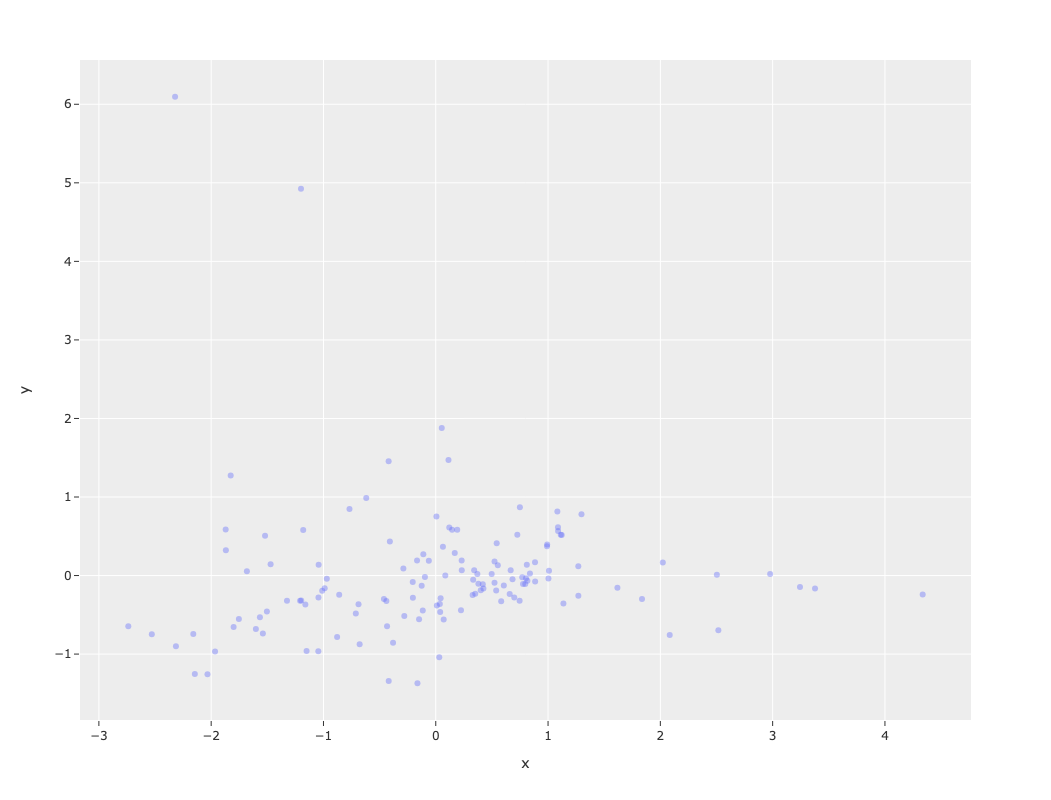

In [99]:
pca = PCA(n_components=2)

vectors_2d = pca.fit_transform(combined_vectors)

fig = px.scatter(
    
    x=vectors_2d[:,0], 
    y=vectors_2d[:,1],
    opacity=0.4, 
    width=800, 
    height=800,
)

fig.show()